In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("/content/breast_cancer_400_entries.csv")

# Basic inspection
print(df.head())
print(df.info())

# Label distribution
print("\nDiagnosis distribution:")
print(df["diagnosis"].value_counts())


   mean_radius  mean_texture  mean_perimeter   mean_area  mean_smoothness  \
0    15.490142     12.622289      106.074257  668.783675         0.096342   
1    13.585207     16.602500       84.259329  585.589169         0.127498   
2    15.943066     19.020975       93.441812  668.344625         0.087081   
3    18.569090     19.187922       85.065871  731.494704         0.084016   
4    13.297540     17.199738       85.482557  657.329011         0.090345   

   mean_compactness  mean_concavity  mean_concave_points  mean_symmetry  \
0          0.066241        0.042261             0.055515       0.185555   
1          0.092774        0.114146             0.130791       0.192763   
2          0.060379        0.056266             0.060494       0.186669   
3          0.084602        0.078268             0.019878       0.218366   
4          0.005319        0.233876             0.047136       0.151431   

   mean_fractal_dimension diagnosis  
0                0.051761         B  
1         

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Separate features and target
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

# Encode labels (M=1, B=0)
le = LabelEncoder()
y = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [4]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_linear = SVC(kernel="linear", random_state=42)
svm_linear.fit(X_train, y_train)

y_pred_linear = svm_linear.predict(X_test)
linear_acc = accuracy_score(y_test, y_pred_linear)

print("Linear SVM Accuracy:", linear_acc)


Linear SVM Accuracy: 0.625


In [5]:
svm_rbf = SVC(kernel="rbf", random_state=42)
svm_rbf.fit(X_train, y_train)

y_pred_rbf = svm_rbf.predict(X_test)
rbf_acc = accuracy_score(y_test, y_pred_rbf)

print("RBF SVM Accuracy:", rbf_acc)


RBF SVM Accuracy: 0.6


In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.01, 0.1, 1, "scale"]
}

grid = GridSearchCV(
    SVC(kernel="rbf", probability=True),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_


Best Parameters: {'C': 0.1, 'gamma': 0.01}


In [7]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_best = best_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=["Benign", "Malignant"]))


Confusion Matrix:
[[50  0]
 [30  0]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.62      1.00      0.77        50
   Malignant       0.00      0.00      0.00        30

    accuracy                           0.62        80
   macro avg       0.31      0.50      0.38        80
weighted avg       0.39      0.62      0.48        80



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


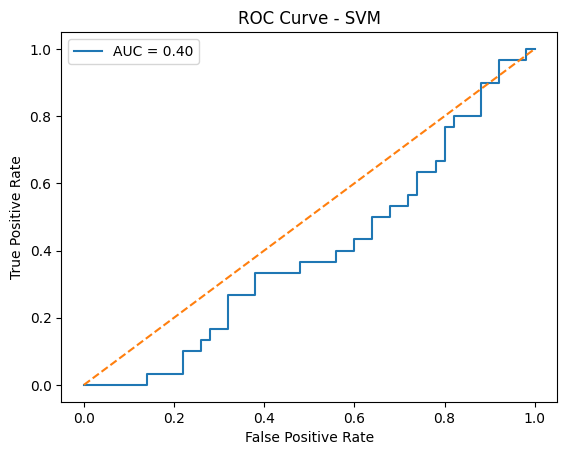

AUC Score: 0.3966666666666667


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_prob = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend()
plt.show()

print("AUC Score:", roc_auc)


In [9]:
import joblib
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", best_model)
])

pipeline.fit(X, y)

joblib.dump(pipeline, "svm_breast_cancer_pipeline.pkl")

print("Model pipeline saved successfully!")


Model pipeline saved successfully!
